# TP Final Analisis de Datos Espaciales

## Clasificador campo / no campo

Al trabajar con datos del agro, es frecuente encontrarse con NAs en las variables `lat, lon`. Para resolver este inconveniente, se suele entrar a Google Maps, escribir la localidad y buscar algun campo a mano para sacar esta información. El problema claro es que este procedimiento **no es escalable** para un alto volumen de NAs, por lo tanto queremos investigar que soluciones alternativas existen.

Después de participar de las clases de ADE se nos ocurrió entrenar un clasificador binario campo / no campo que, dado un raster de imágenes satelitales, identifique satisfactoriamente las potenciales ubicaciones de donde sacar coordenadas. Esto podría solucionar nuestro problema, ahorrando muchisimo tiempo al proceso de analizar datos agro.

## Encontramos un paper

 [*"Automating field boundary delineation with multi-temporal Sentinel-2 imagery"*](https://www.researchgate.net/publication/337182705_Automating_field_boundary_delineation_with_multi-temporal_Sentinel-2_imagery)

 Usan técnicas de aprendizaje no supervisado que nos gustaría investigar (Canny Edge Detection, Watershed Segmentation) y comparar con un clasficiador supervisado por pixel. Los autores del paper sostienen que el análisis de imagen orientado a objetos (OBIA) supera limitaciones de las clasificaciones por pixel al **eliminar la necesidad de datos de entrenamiento y mejorar la precision espacial** al delinear limites de campo cerrados.

### Objetivo general

Nuestro objetivo general es diseñar y evaluar un método automático para detectar y delimitar áreas de campo agrícola a partir de imagenes multitemporales de Sentinel-2.

Queremos utilizar un método del paper que clasifica campos, no por píxel, sino por un conjunto de ellos que selecciona mediante el metodo canny y watershed segmentation.

* Canny ayuda a distiguir Bordes, zonas donde el valor cambia bruscamente → como el límite entre dos parcelas.

* Watershed crea regiones cerradas, posibles campos agrícolas.

Objetivos específicos

1. Construir una representación multi-temporal por píxel (características espectrales y fenológicas) a partir de series Sentinel-2.

2. Implementar un pipeline no supervisado de delineación de campos basado en detección de bordes (Canny) + Watershed (según paper) y extraer segmentos candidatos.

3. a) En este punto no sabemos si usar un modelo supervisado donde usamos datos secundarios para crear etiquetas automáticas débiles. Por ejemplo Zonas urbanas de OpenStreetMap → etiquetamos como “no campo”, extraer polígonos de áreas rurales por la pag oficial del gobierno IGN y/o eliminación automática de cuerpos de agua, infraestructura, ciudades.
  
     b) La otra opcion podria ser un modelo no supervisado, clustering. Donde se analiza cada cluster y se asigna etiqueta por interpretación visual o por porcentaje de presencia rural.



4. Evaluar la precisión de detección y la utilidad práctica para imputar coordenadas.

### Un poquito más detallado.

### Canny
* Suaviza la imagen (ruido ↓)

* Calcula gradiente de intensidad

* Detecta máximos de gradiente (posibles bordes)

* Aplica umbrales para quedarse con bordes significativos

* Conecta bordes en líneas limpias


### Watershed

Imagina la imagen como un mapa de alturas:

* Los valores bajos = valles (cuencas)

* Los valores altos = cimas

Luego:

* “Llenan de agua” los valles

* Cuando dos cuencas se encuentran → aparece una línea divisoria

* Esas líneas son segmentaciones (regiones)

una vez obtenida las regiones se extraen los segmentos candidatos que queremos (campo), para eso filtrariamos según criterios geompetricos o espectrales. (Área mínima:	Campos no suelen ser muy pequeños, por su forma	los lotes suelen tener formas regulares, por su NDVI medio alto: Vegetación presente y por su variabilidad temporal: Cultivos cambian a lo largo del tiempo.

## Rasters INTA

Descargamos RASTERS de la campaña agricola 23/24, hay un raster para invierno y otro para verano.


In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage import feature, filters, segmentation, morphology
from scipy import ndimage as ndi
import os
import rasterio
import pandas as pd
r_rasters = r"..\data\raw\sentinel_23_24"
r_inta = r"..\data\raw\INTA_23_24"


In [3]:
# Mostrar solo características de los raster .tif en r_inta

inta_tif_files = glob.glob(os.path.join(r_inta, "*.tif"))

if len(inta_tif_files) == 0:
    print(f"No se encontraron archivos .tif en {r_inta}")
else:
    print(f"Se encontraron {len(inta_tif_files)} archivos .tif en {r_inta}\n")
    for idx, tif_path in enumerate(inta_tif_files, 1):
        with rasterio.open(tif_path) as src:
            print(f"Raster {idx}: {os.path.basename(tif_path)}")
            print(f"\tDimensiones (alto, ancho): {src.height} x {src.width}")
            print(f"\tN° bandas: {src.count}")
            print(f"\tTipo de dato: {src.dtypes[0]}")
            print(f"\tCRS: {src.crs}")
            print(f"\tPixel size (resolución): {src.res[0]} x {src.res[1]}")
            print(f"\tExtensión (bounds): {src.bounds}\n")


Se encontraron 2 archivos .tif en ..\data\raw\INTA_23_24

Raster 1: MNC_invierno2023.tif
	Dimensiones (alto, ancho): 70641 x 43994
	N° bandas: 1
	Tipo de dato: uint8
	CRS: EPSG:4326
	Pixel size (resolución): 0.0002694945852388963 x 0.0002694945852408658
	Extensión (bounds): BoundingBox(left=-67.476323746, bottom=-41.035940494, right=-55.620178963, top=-21.998573498)

Raster 2: MNC_verano-2024.tif
	Dimensiones (alto, ancho): 70641 x 43994
	N° bandas: 1
	Tipo de dato: uint8
	CRS: EPSG:4326
	Pixel size (resolución): 0.0002694945852388963 x 0.0002694945852408658
	Extensión (bounds): BoundingBox(left=-67.476323746, bottom=-41.035940494, right=-55.620178963, top=-21.998573498)



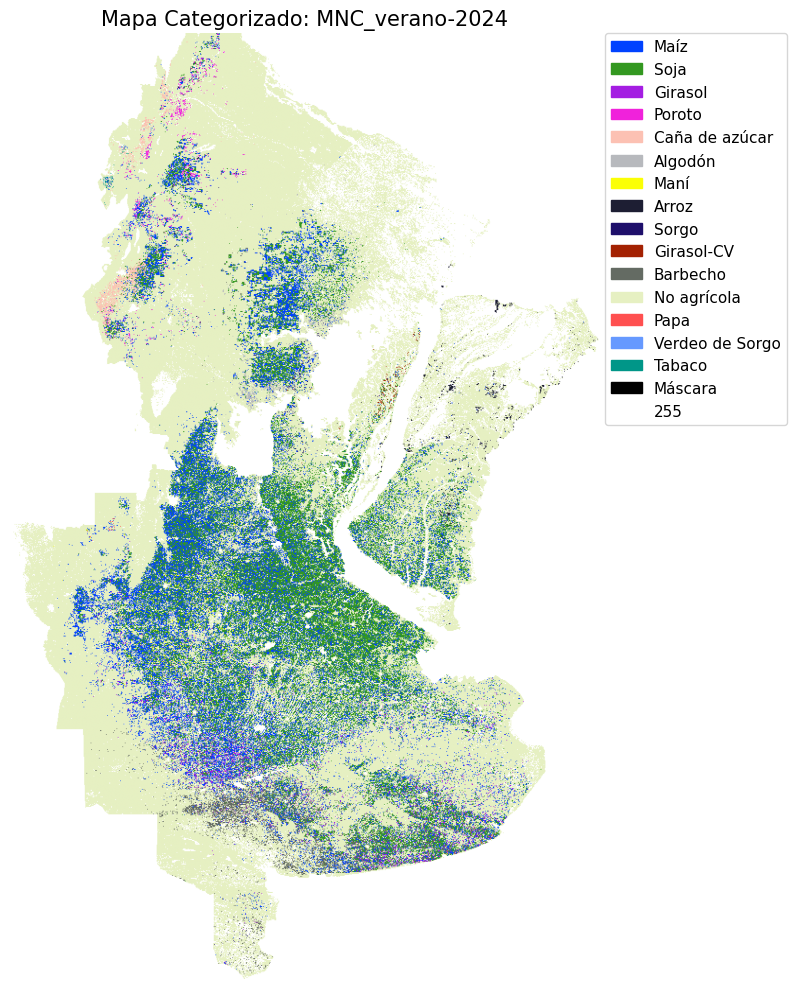

Imagen categorizada guardada en: img\MNC_verano-2024_categorizado.png


In [12]:

import xml.etree.ElementTree as ET
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import rasterio
import rasterio.enums
import os

# Paths
tif_path = os.path.join(r_inta, "MNC_verano-2024.tif")
qml_path = os.path.join("..","data", "raw", "INTA_23_24", "MNC_ver24.qml")
out_dir = "img"
os.makedirs(out_dir, exist_ok=True)
png_out_path = os.path.join(out_dir, "MNC_verano-2024_categorizado.png")

# --- Parse QML for classes/colors ---
tree = ET.parse(qml_path)
root = tree.getroot()

# Encontrar el nodo <colorrampshader>
shader = root.find(".//colorrampshader")
items = shader.findall(".//item")

# Extraer valores, etiquetas y colores - permitiendo tanto "R,G,B,A" como "#RRGGBB"
labels = []
vals = []
hex_colors = []
for it in items:
    vals.append(int(float(it.get("value"))))
    labels.append(it.get("label"))
    qml_col = it.get("color")
    if qml_col.startswith("#"):  # hexadecimal color
        # Si es, por ejemplo, "#0042ff", simplemente lo usamos.
        hex_colors.append(qml_col.lower())
    else:
        # formateo "R,G,B,A"
        rgb_split = qml_col.split(",")
        if len(rgb_split) >= 3:
            try:
                rgb = tuple(map(int, rgb_split[:3]))
                hex_colors.append('#{:02x}{:02x}{:02x}'.format(*rgb))
            except Exception as e:
                # Fallback: gris, y advertimos
                hex_colors.append("#888888")
                print(f"[WARN] No se pudo interpretar color '{qml_col}': {e}")
        else:
            # Si no se puede interpretar, asignamos un color default
            hex_colors.append("#888888")
            print(f"[WARN] Color desconocido para item con label '{it.get('label')}': '{qml_col}'")

# Ordenar por valor
z = sorted(zip(vals, hex_colors, labels), key=lambda t: t[0])
vals, hex_colors, labels = [list(x) for x in zip(*z)]

# Para BoundaryNorm, los boundaries deben ser valores exactos de corte de clase
boundaries = vals + [vals[-1] + 1]  # boundary superior 1 por encima

cmap = ListedColormap(hex_colors)
norm = BoundaryNorm(boundaries, ncolors=len(hex_colors))

# --- Leer el raster y muestrear low-res ---
with rasterio.open(tif_path) as src:
    W_preview, H_preview = 1000, 1000
    img = src.read(
        1,
        out_shape=(H_preview, W_preview),
        resampling=rasterio.enums.Resampling.nearest
    )
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

plt.figure(figsize=(10,10))
im = plt.imshow(img, cmap=cmap, norm=norm, extent=extent, origin='upper')
plt.title("Mapa Categorizado: MNC_verano-2024", fontsize=15)
plt.axis("off")
# Hacer una leyenda custom
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=hex_colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=11)
plt.tight_layout()
plt.savefig(png_out_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Imagen categorizada guardada en: {png_out_path}")



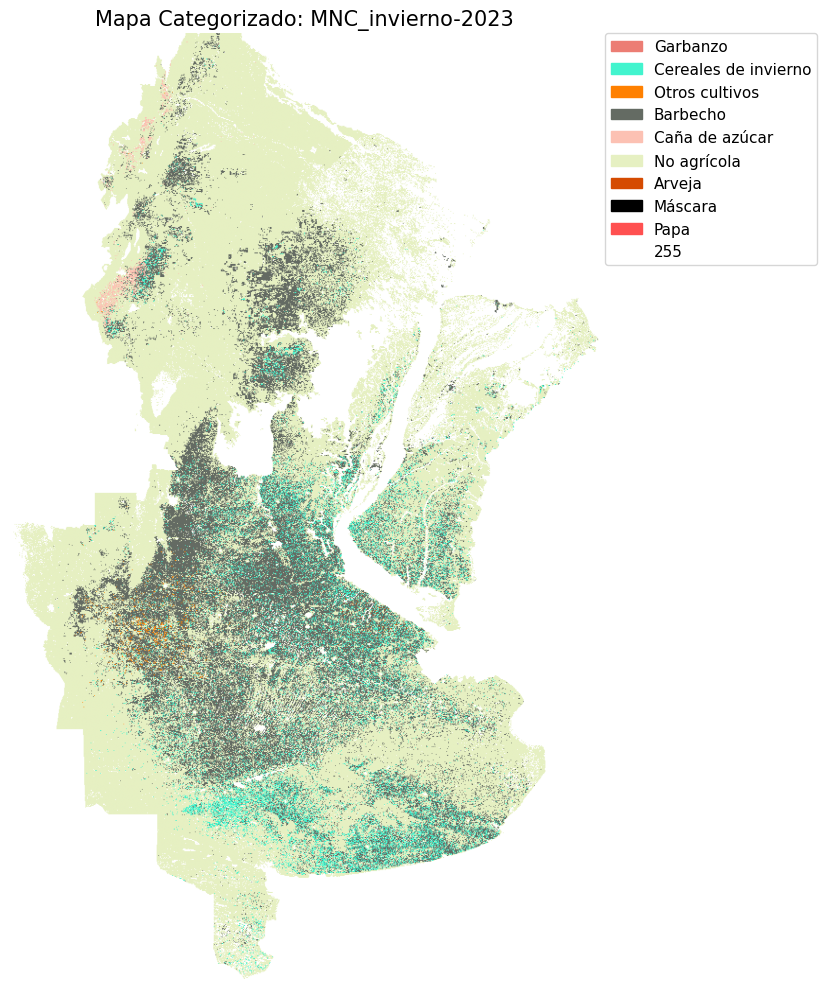

Imagen categorizada guardada en: img\MNC_invierno2023_categorizado.png


In [16]:

# --- Visualización categorizada: INVIERNO (MNC_inv23.qml & MNC_invierno2023.tif) ---

# Paths a archivos invierno (manteniendo consistencia con el bloque anterior)
tif_path_inv = os.path.join(r_inta, "MNC_invierno2023.tif")
qml_path_inv = os.path.join("..", "data", "raw", "INTA_23_24", "MNC_inv23.qml")
png_out_path_inv = os.path.join(out_dir, "MNC_invierno2023_categorizado.png")

# --- Parsear la leyenda del QML de invierno ---
from xml.etree import ElementTree as ET

tree_inv = ET.parse(qml_path_inv)
root_inv = tree_inv.getroot()

labels_inv = []
vals_inv = []
hex_colors_inv = []

for it in root_inv.iter('item'):
    label = it.get('label')
    value = it.get('value')
    color = it.get('color')
    if label and value:
        labels_inv.append(label)
        vals_inv.append(int(float(value)))
        qml_col = color
        if qml_col is None:
            hex_colors_inv.append("#888888")
            continue
        if qml_col.startswith("#"):
            hex_colors_inv.append(qml_col)
        elif "," in qml_col:
            rgb_split = qml_col.split(",")
            try:
                rgb = tuple(map(int, rgb_split[:3]))
                hex_colors_inv.append('#{:02x}{:02x}{:02x}'.format(*rgb))
            except Exception as e:
                hex_colors_inv.append("#888888")
                print(f"[WARN] No se pudo interpretar color '{qml_col}': {e}")
        else:
            hex_colors_inv.append("#888888")
            print(f"[WARN] Color desconocido para item con label '{it.get('label')}': '{qml_col}'")

# Ordenar por valor
z_inv = sorted(zip(vals_inv, hex_colors_inv, labels_inv), key=lambda t: t[0])
vals_inv, hex_colors_inv, labels_inv = [list(x) for x in zip(*z_inv)]

# Para BoundaryNorm, los boundaries deben ser valores exactos de corte de clase
boundaries_inv = vals_inv + [vals_inv[-1] + 1]  # boundary superior 1 por encima

cmap_inv = ListedColormap(hex_colors_inv)
norm_inv = BoundaryNorm(boundaries_inv, ncolors=len(hex_colors_inv))

# --- Leer el raster y muestrear low-res ---
with rasterio.open(tif_path_inv) as src_inv:
    W_preview, H_preview = 1000, 1000
    img_inv = src_inv.read(
        1,
        out_shape=(H_preview, W_preview),
        resampling=rasterio.enums.Resampling.nearest
    )
    extent_inv = [src_inv.bounds.left, src_inv.bounds.right, src_inv.bounds.bottom, src_inv.bounds.top]

plt.figure(figsize=(10,10))
im_inv = plt.imshow(img_inv, cmap=cmap_inv, norm=norm_inv, extent=extent_inv, origin='upper')
plt.title("Mapa Categorizado: MNC_invierno-2023", fontsize=15)
plt.axis("off")
import matplotlib.patches as mpatches
handles_inv = [mpatches.Patch(color=hex_colors_inv[i], label=labels_inv[i]) for i in range(len(labels_inv))]
plt.legend(handles=handles_inv, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=11)
plt.tight_layout()
plt.savefig(png_out_path_inv, dpi=200, bbox_inches='tight')
plt.show()
print(f"Imagen categorizada guardada en: {png_out_path_inv}")



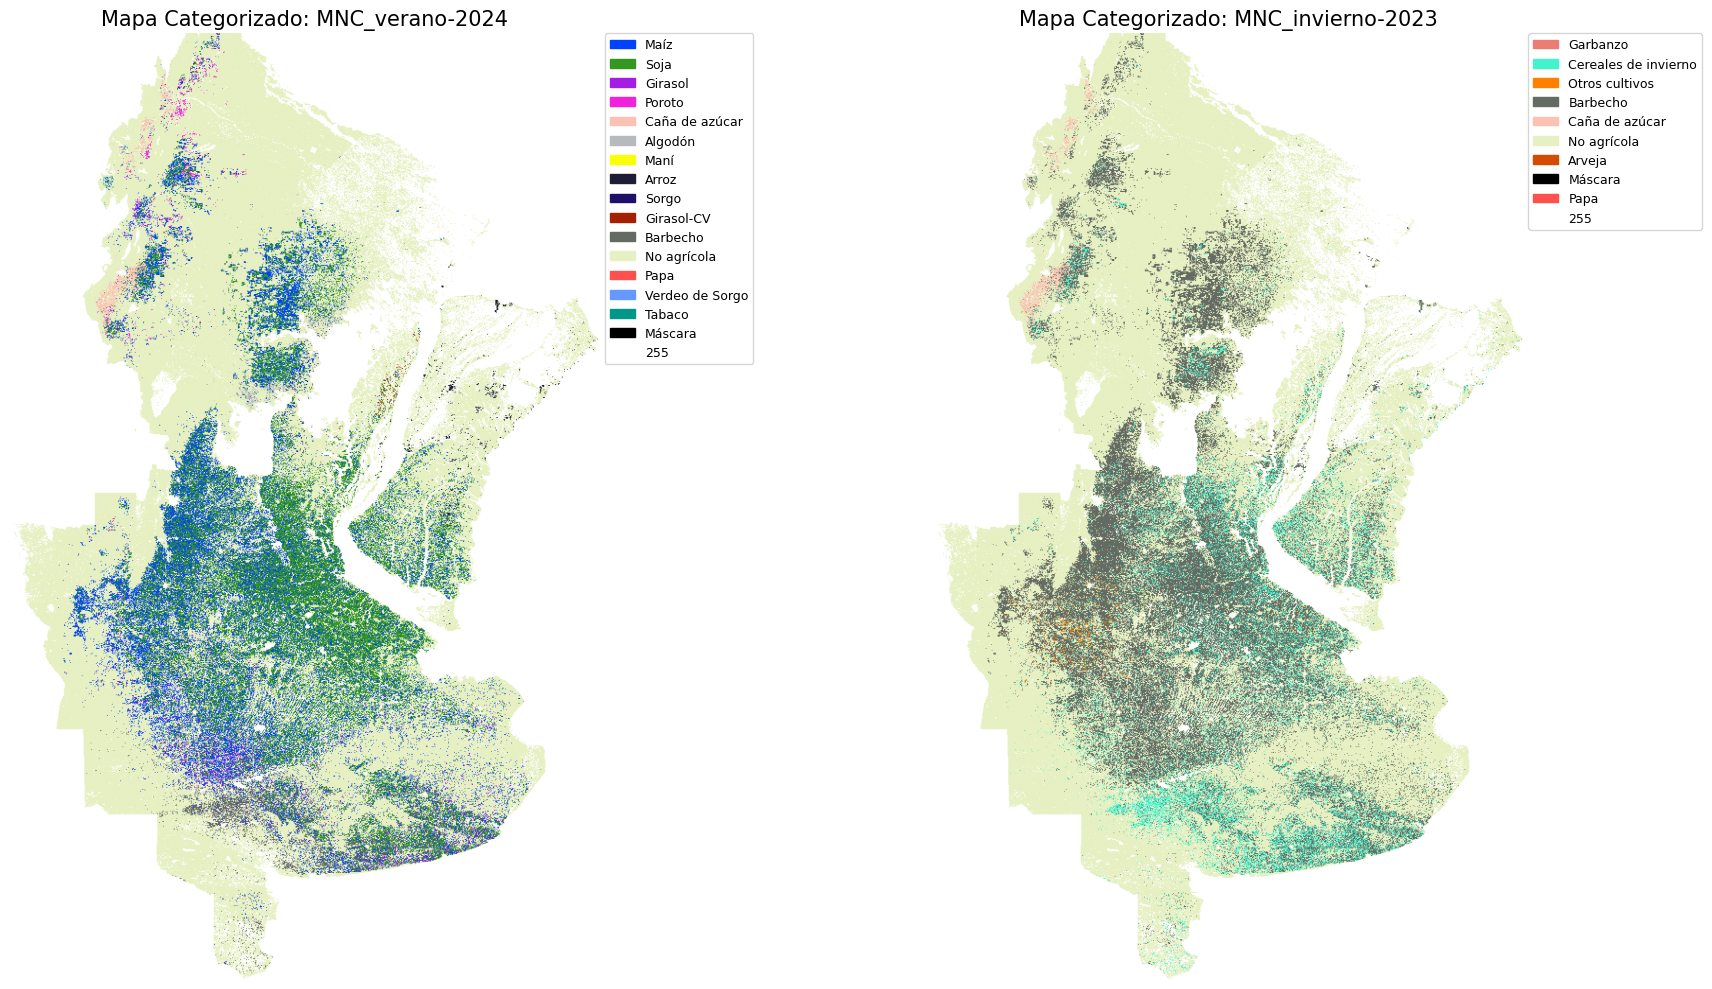

Imagen combinada guardada en: img\MNC_verano_invierno_combinado.png


In [18]:
# --- Visualización combinada: Verano e Invierno lado a lado ---

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot izquierdo: Verano
axes[0].imshow(img, cmap=cmap, norm=norm, extent=extent, origin='upper')
axes[0].set_title("Mapa Categorizado: MNC_verano-2024", fontsize=15)
axes[0].axis("off")
handles_ver = [mpatches.Patch(color=hex_colors[i], label=labels[i]) for i in range(len(labels))]
axes[0].legend(handles=handles_ver, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=9)

# Plot derecho: Invierno
axes[1].imshow(img_inv, cmap=cmap_inv, norm=norm_inv, extent=extent_inv, origin='upper')
axes[1].set_title("Mapa Categorizado: MNC_invierno-2023", fontsize=15)
axes[1].axis("off")
handles_inv = [mpatches.Patch(color=hex_colors_inv[i], label=labels_inv[i]) for i in range(len(labels_inv))]
axes[1].legend(handles=handles_inv, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=9)

plt.tight_layout()
png_out_path_combined = os.path.join(out_dir, "MNC_verano_invierno_combinado.png")
plt.savefig(png_out_path_combined, dpi=200, bbox_inches='tight')
plt.show()
print(f"Imagen combinada guardada en: {png_out_path_combined}")


## Visualizaciones para comparar NDVI a lo largo del tiempo


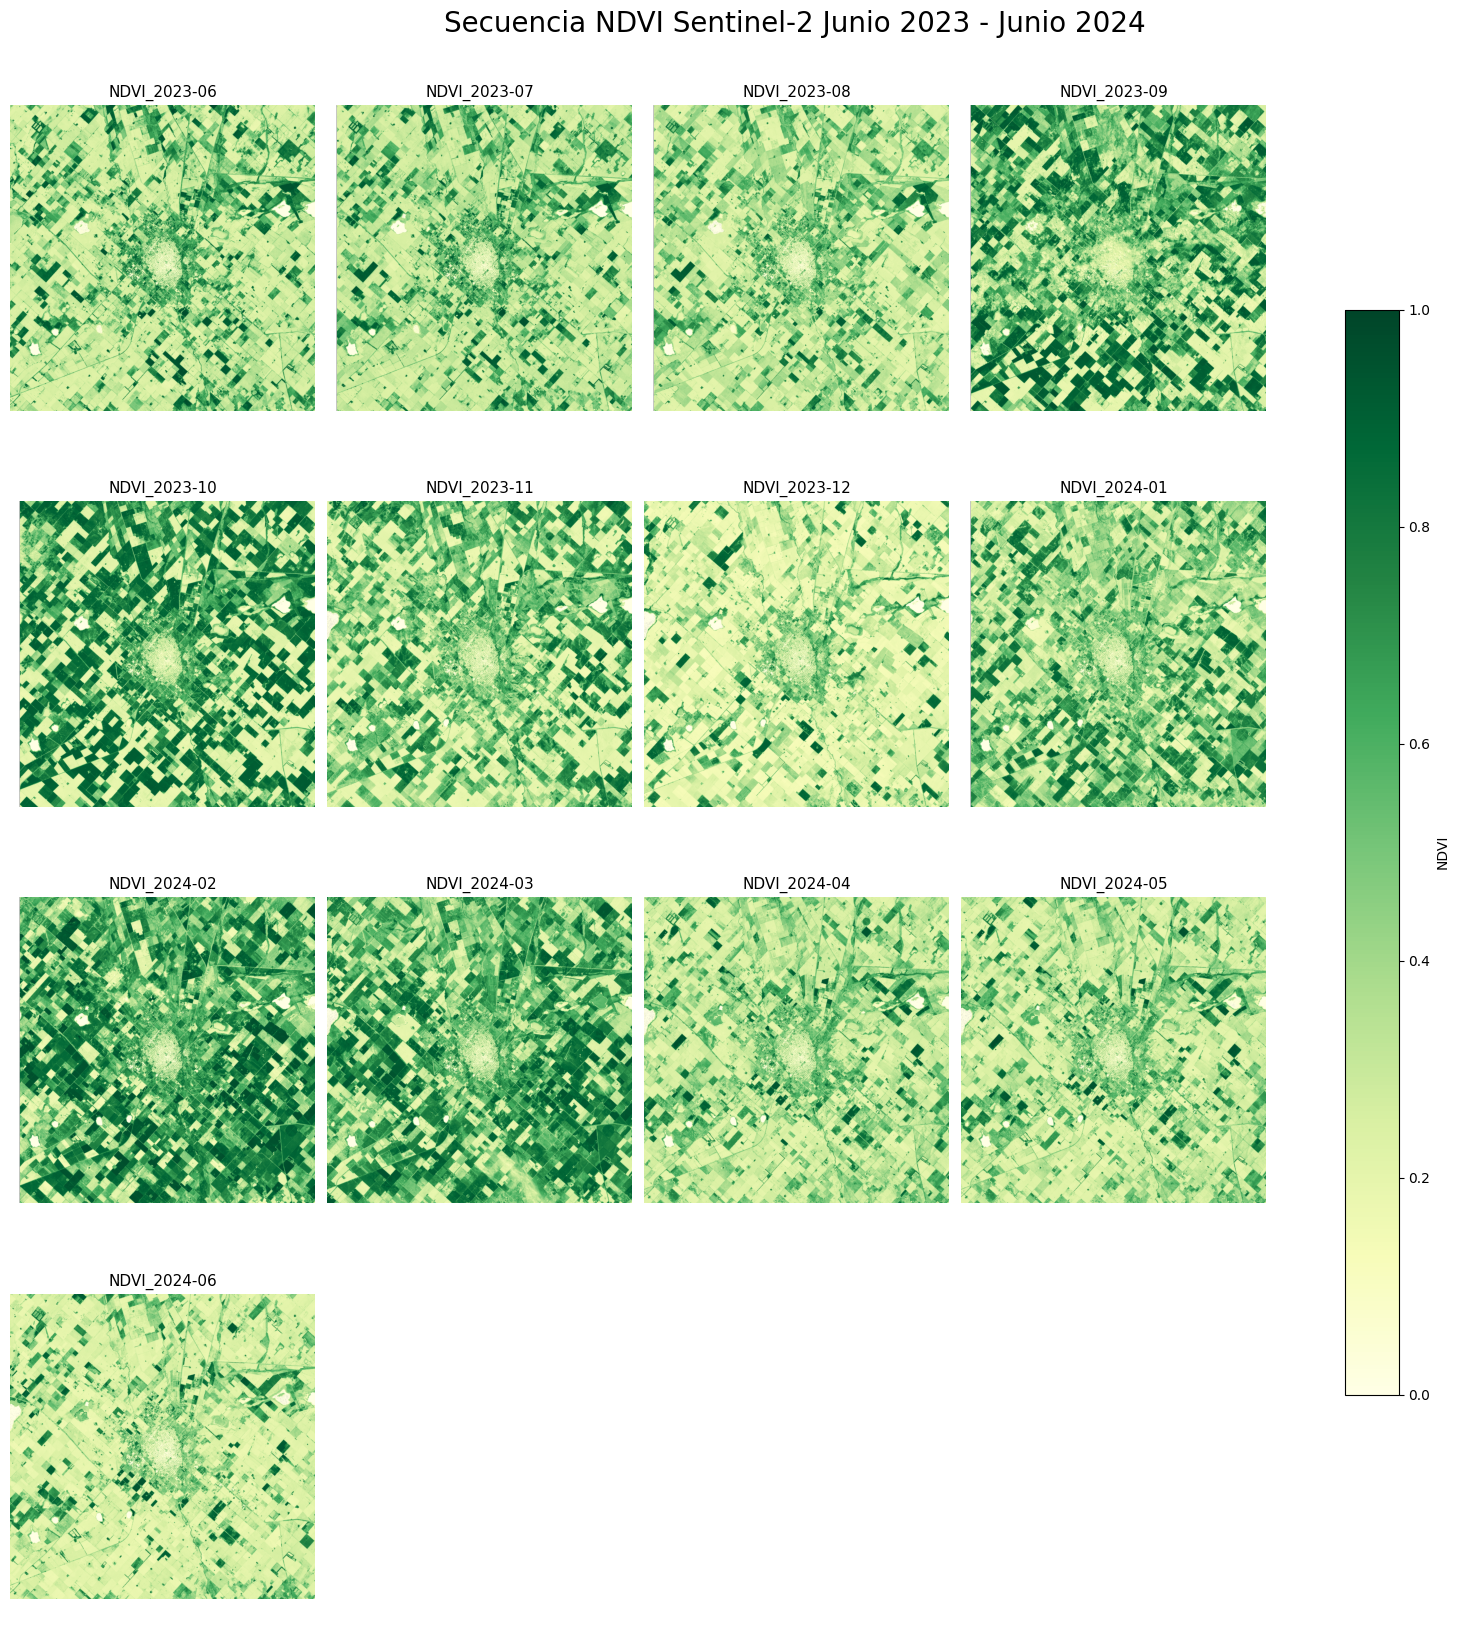

In [20]:
import os
import matplotlib.pyplot as plt
import rasterio

# Definir la ruta al directorio donde buscar archivos
data_dir = os.path.join("..", "data", "raw", "sentinel_23_24")

# Secuencia exacta de archivos .tif según la imagen
archivos = [
    "NDVI_2023-06.tif",
    "NDVI_2023-07.tif",
    "NDVI_2023-08.tif",
    "NDVI_2023-09.tif",
    "NDVI_2023-10.tif",
    "NDVI_2023-11.tif",
    "NDVI_2023-12.tif",
    "NDVI_2024-01.tif",
    "NDVI_2024-02.tif",
    "NDVI_2024-03.tif",
    "NDVI_2024-04.tif",
    "NDVI_2024-05.tif",
    "NDVI_2024-06.tif",
]

n = len(archivos)
ncols = 4
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

for idx, archivo in enumerate(archivos):
    fpath = os.path.join(data_dir, archivo)
    row, col = divmod(idx, ncols)
    ax = axes[row, col] if nrows > 1 else axes[col]
    with rasterio.open(fpath) as src:
        img = src.read(1)
        img[img == src.nodata] = None
        im = ax.imshow(img, cmap="YlGn", vmin=0, vmax=1)
    ax.set_title(archivo.split('.')[0], fontsize=11)
    ax.axis("off")

# Si hay ejes vacíos, desactivarlos
for i in range(n, nrows*ncols):
    row, col = divmod(i, ncols)
    ax = axes[row, col] if nrows > 1 else axes[col]
    ax.axis("off")

plt.tight_layout()
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7, label='NDVI')
plt.suptitle("Secuencia NDVI Sentinel-2 Junio 2023 - Junio 2024", fontsize=20, y=1.02)
plt.show()


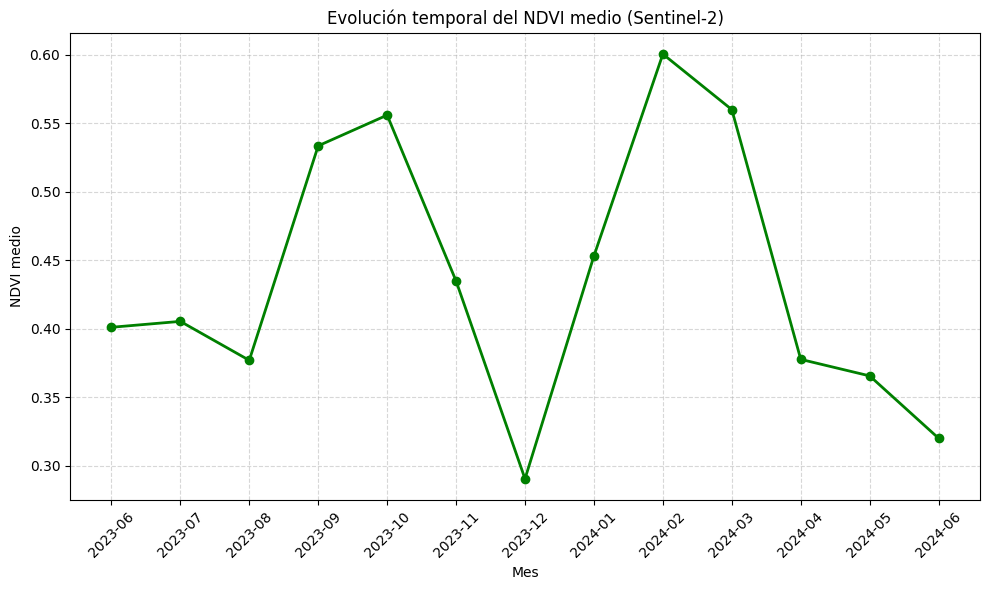

In [21]:
import numpy as np

# Crear una lista para guardar la media de NDVI de cada raster
ndvi_means = []
meses = [
    "2023-06", "2023-07", "2023-08", "2023-09", "2023-10", "2023-11", "2023-12",
    "2024-01", "2024-02", "2024-03", "2024-04", "2024-05", "2024-06"
]

for archivo in archivos:
    fpath = os.path.join(data_dir, archivo)
    with rasterio.open(fpath) as src:
        img = src.read(1)
        # Enmascara nodata (que se puso como None antes)
        if src.nodata is not None:
            mask = img != src.nodata
            ndvi_mean = img[mask].mean()
        else:
            ndvi_mean = np.nanmean(img)
        ndvi_means.append(ndvi_mean)

# Graficar
plt.figure(figsize=(10,6))
plt.plot(meses, ndvi_means, marker='o', color='green', linewidth=2)
plt.xticks(rotation=45)
plt.xlabel("Mes")
plt.ylabel("NDVI medio")
plt.title("Evolución temporal del NDVI medio (Sentinel-2)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
